In [1]:
import requests
import math

# API endpoint URL (example with OpenWeatherMap API)
api_url = "http://api.openweathermap.org/data/2.5/weather?q=Jakarta&appid=db8cf5bde518565c88da2ca1a058fc0d"

# Make the GET request
response = requests.get(api_url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse JSON data from the response
    data = response.json()
 
    # Access wind speed and gust
    wind_speed = data['wind']['speed']
    wind_degree = data['wind']['deg']
    wind_degree_radians = math.radians(wind_degree)

    # Print the data (e.g., weather description)
    weather_description = data['weather'][0]['description']
    temperature = data['main']['temp'] - 273.15  # Convert from Kelvin to Celsius
    humidity_levels = data['main']['humidity']
    
    # Calculate the x and y components of the wind
    wind_x = wind_speed * math.cos(wind_degree_radians)  # East-West component
    wind_y = wind_speed * math.sin(wind_degree_radians)  # North-South component


    # speed_to_gust_ratio = data['wind'][0]['speed'] / data['wind'][0]['gust']
    print(f"Weather: {weather_description}")
    print(f"Temperature: {temperature:.2f}°C")
    print(f"Humidity: {humidity_levels}%")
    print(f"Wind X-Component (East-West): {wind_x:.2f} m/s")
    print(f"Wind Y-Component (North-South): {wind_y:.2f} m/s")
    
    
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")


Weather: haze
Temperature: 32.86°C
Humidity: 57%
Wind X-Component (East-West): 5.06 m/s
Wind Y-Component (North-South): 0.89 m/s


In [3]:
import requests
import time
from datetime import datetime
import pandas as pd
import smtplib
from email.mime.text import MIMEText

# Replace with your OpenWeather API key
api_key = "db8cf5bde518565c88da2ca1a058fc0d"
city = "Jakarta"
url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}"

def fetch_weather_data():
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        # Return useful information
        weather_info = {
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'temperature': data['main']['temp'] - 273.15,  # Kelvin to Celsius
            'wind_speed': data['wind']['speed'],
            
            'humidity': data['main']['humidity'],
            'weather': data['weather'][0]['description']
        }
        return weather_info
    else:
        print(f"Failed to fetch data. HTTP Status code: {response.status_code}")
        return None


In [6]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://historical-forecast-api.open-meteo.com/v1/forecast"

In [7]:
import requests
import requests_cache
import pandas as pd
from retry_requests import retry
from datetime import datetime, timedelta

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)

# Define the base URL for Open-Meteo historical data API
url = "https://api.open-meteo.com/v1/forecast"

# Example function to fetch historical weather data for a specific day
def fetch_historical_weather(lat, lon, date):
    # Format the date for the API query
    start_date = date
    end_date = date
    
    # Define the API parameters (hourly temperature data for the given date)
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": "temperature_2m",  # You can also request other variables here (e.g., wind_speed, humidity)
        "start_date": start_date,
        "end_date": end_date,
    }
    
    # Make the request
    response = retry_session.get(url, params=params)
    if response.status_code == 200:
        return response.json()  # Return JSON data from the response
    else:
        print(f"Error fetching data for {date}. Status code: {response.status_code}")
        return None

# Example: Fetch data for Jakarta (latitude: -6.2088, longitude: 106.8456)
lat = -6.2088
lon = 106.8456
date = (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d')  # Fetch data for yesterday

# Fetch the historical data
data = fetch_historical_weather(lat, lon, date)

# If data is successfully fetched, process it
if data:
    # Extract hourly temperature data
    temperatures = data['hourly']['temperature_2m']
    times = data['hourly']['time']
    
    # Create a DataFrame with the fetched data
    df = pd.DataFrame({
        'time': times,
        'temperature': temperatures
    })
    
    print(df)


                time  temperature
0   2024-11-25T00:00         26.6
1   2024-11-25T01:00         27.8
2   2024-11-25T02:00         29.0
3   2024-11-25T03:00         30.2
4   2024-11-25T04:00         31.5
5   2024-11-25T05:00         32.8
6   2024-11-25T06:00         32.7
7   2024-11-25T07:00         32.9
8   2024-11-25T08:00         31.5
9   2024-11-25T09:00         30.3
10  2024-11-25T10:00         29.8
11  2024-11-25T11:00         29.3
12  2024-11-25T12:00         29.3
13  2024-11-25T13:00         29.0
14  2024-11-25T14:00         28.8
15  2024-11-25T15:00         28.7
16  2024-11-25T16:00         28.4
17  2024-11-25T17:00         27.9
18  2024-11-25T18:00         27.2
19  2024-11-25T19:00         26.8
20  2024-11-25T20:00         26.4
21  2024-11-25T21:00         26.1
22  2024-11-25T22:00         25.8
23  2024-11-25T23:00         25.7


In [8]:
for lag in range(1, 25):  # Create 1 to 24-hour lag features
    df[f'lag_{lag}'] = df['temperature'].shift(lag)
df = df.dropna()  # Remove rows with NaN values after shifting



In [25]:
import requests
import pandas as pd

# Set the Open-Meteo API endpoint and your parameters (e.g., temperature)
url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": -6.1818,  # Example latitude for Berlin
    "longitude": 106.8223,  # Example longitude for Berlin
    "hourly": "temperature_2m",
    "start": "2024-11-24T00:00:00Z",  # Start time
    "end": "2024-11-24T23:00:00Z"    # End time
}

# Fetch data from Open-Meteo
response = requests.get(url, params=params)
data = response.json()

# Extract the hourly temperature data
temperatures = data['hourly']['temperature_2m']
dates = pd.to_datetime(data['hourly']['time'])

# Create a DataFrame
df = pd.DataFrame({
    'date': dates,
    'temperature': temperatures
})

print(df.head())


                 date  temperature
0 2024-11-26 00:00:00         27.2
1 2024-11-26 01:00:00         28.6
2 2024-11-26 02:00:00         30.6
3 2024-11-26 03:00:00         32.7
4 2024-11-26 04:00:00         34.1


In [26]:
df['temperature_1day_lag'] = df['temperature'].shift(1)
df['temperature_2day_lag'] = df['temperature'].shift(2)
df['temperature_3day_lag'] = df['temperature'].shift(3)
df.dropna(inplace=True)

X = df[['temperature_1day_lag', 'temperature_2day_lag', 'temperature_3day_lag']]
y = df['temperature']


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

# Predict future values (next day's temperature)
forecast = model.predict(X_test)

print(forecast)  # Predicted temperatures


[26.57   27.726  27.268  30.376  30.446  31.168  27.024  31.715  33.095
 32.017  26.378  28.58   27.391  27.352  30.885  30.584  27.071  28.967
 29.579  26.944  34.395  26.615  27.576  29.199  30.486  28.022  34.603
 30.025  26.6575 26.616  26.246  33.105  28.169 ]


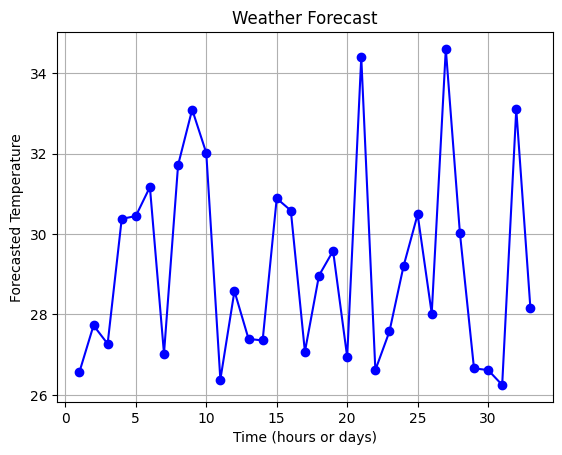

In [27]:
import matplotlib.pyplot as plt

# Assuming 'forecast' is the array you posted
forecast = [26.57, 27.726 , 27.268,  30.376 , 30.446 , 31.168,  27.024 , 31.715,  33.095,
    32.017,  26.378 , 28.58 ,  27.391,  27.352 , 30.885,  30.584 , 27.071 , 28.967,
    29.579,  26.944 , 34.395 , 26.615 , 27.576 ,29.199 , 30.486 , 28.022 , 34.603,
    30.025 , 26.6575, 26.616,  26.246 , 33.105 , 28.169 ]

# Generate a simple time index (e.g., for hourly data)
time_index = range(1, len(forecast) + 1)

# Plot the forecast
plt.plot(time_index, forecast, marker='o', linestyle='-', color='b')
plt.title("Weather Forecast")
plt.xlabel("Time (hours or days)")
plt.ylabel("Forecasted Temperature")
plt.grid(True)
plt.show()


(132, 3) (33, 3) (132,) (33,)
    temperature_1day_lag  temperature_2day_lag  temperature_3day_lag
87                  29.5                  30.0                  30.6
5                   34.1                  32.7                  30.6
97                  27.9                  27.4                  27.4
48                  26.9                  26.9                  26.9
45                  26.9                  27.0                  27.0
87    29.0
5     34.8
97    29.2
48    27.2
45    26.9
Name: temperature, dtype: float64
MAE: 0.30521212121212365, RMSE: 0.4162582786509587


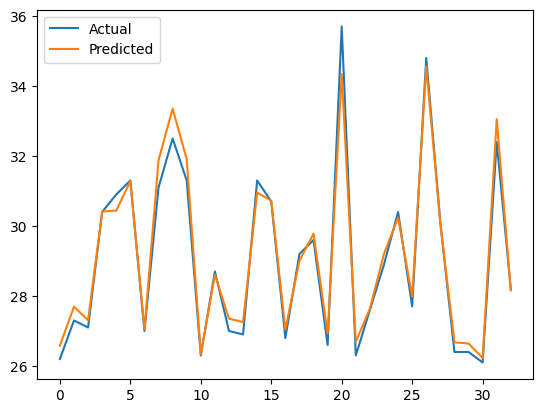

In [18]:
# Step 1: Check feature and target data
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_train.head())
print(y_train.head())

# Step 2: Scale the data (optional)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 3: Train and predict
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
forecast = model.predict(X_test)

# Step 4: Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, forecast)
rmse = np.sqrt(mean_squared_error(y_test, forecast))

print(f"MAE: {mae}, RMSE: {rmse}")

# Step 5: Visualize
import matplotlib.pyplot as plt

plt.plot(y_test.values, label='Actual')
plt.plot(forecast, label='Predicted')
plt.legend()
plt.show()
